# Global warming analysis & predictions

The following kernel aims to study the time series of the Earth's temperature in order to address the issue of global warming.
The dataset used was made available by [Berkeley Earth](http://berkeleyearth.org/about/) organization and contains data relating to the Land & Oceans temperature of the Earth since 1750. The study of the earth's temperature is a time series that depends on many physical variables:
- variations in the sun's energy reaching Earth
- changes in the reflectivity of the Earth's atmosphere and surface
- changes in the greenhouse effect which affects the amount of the heat retained by Earth's atmosphere

Each of these physical variables is a function of time. Therefore, the models used are extremely heavy complex physical models.

The following kernel aims to use a purely statistical method, the ARIMA (Autoregressive integrated moving average) method. Usually this method is used in the analysis of economic series. This notebook intends to study its behavior for the analysis of a physical series such as that of the Earth's temperature.

# Table of Contents:
* **1. [Libraries](#Libraries)** <br>
* **2. [Data Analysis](#Data_Analysis)** <br>
* **3. [Time series stationarity analysis](#Time_series_analysis)** <br>
* ** 3.1 [Augmented Dickey Fuller test](#Dickey_Fuller_test) <br>
* ** 3.2 [Kpss test](#Kpss_test) <br>
* **4. [Predictions with ARIMA model](#ARIMA)** <br>
* **5. [Conclusions](#Conclusions)** <br>


<a id="Libraries"></a> <br> 
# **1. Libraries** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
import datetime 

In [2]:
# Install pmdarima package. It will be usefull to build the ARIMA model.
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 6.1 MB/s 


In [3]:
from pmdarima.arima import auto_arima

<a id="Data_Analysis"></a> <br> 
# **2. Data Analysis** 

In [4]:
# Read Earth temperature dataset
earthTemp = pd.read_csv('../input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv',index_col='dt') #parse_dates=['dt'])
earthTemp.head(5)

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# See how many null values for each column
earthTemp.isnull().sum()

LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

In this kernel, we will analyse the Land and Ocean Average Temperature

In [6]:
# Remove lines where the Land & Ocean temperature is null
earthTemp = earthTemp[earthTemp['LandAndOceanAverageTemperature'].notnull()]

In [7]:
# Show dataset size
earthTemp.shape

(1992, 8)

In [8]:
# See new dataframe
earthTemp.head(5)

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249


In [9]:
# Convert dt column elements to datetime object
earthTemp.index = pd.to_datetime(earthTemp.index, format='%Y-%m-%d')  # transform string dates to datatime objects

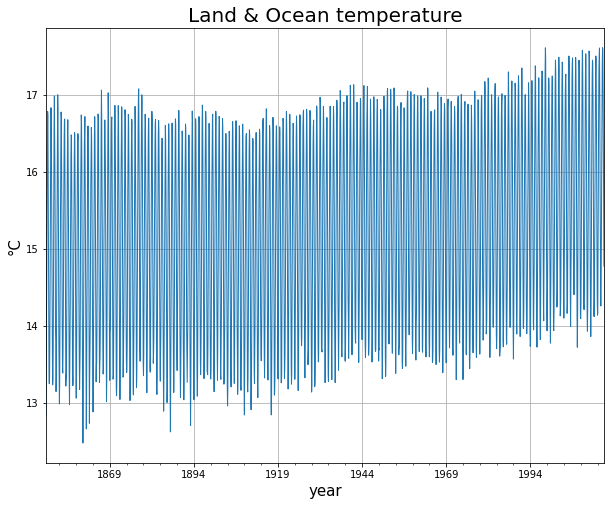

In [10]:
# Get the average temperature for each year and plot the global trend from 1850 year
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
earthTemp["LandAndOceanAverageTemperature"].plot(linewidth=1)
plt.title('Land & Ocean temperature', fontsize=20)
plt.xlabel('year', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.grid(True)


The time series seems to shows a trend and periodicity. To better visualize the trend, we calculate the average temperature for each year.

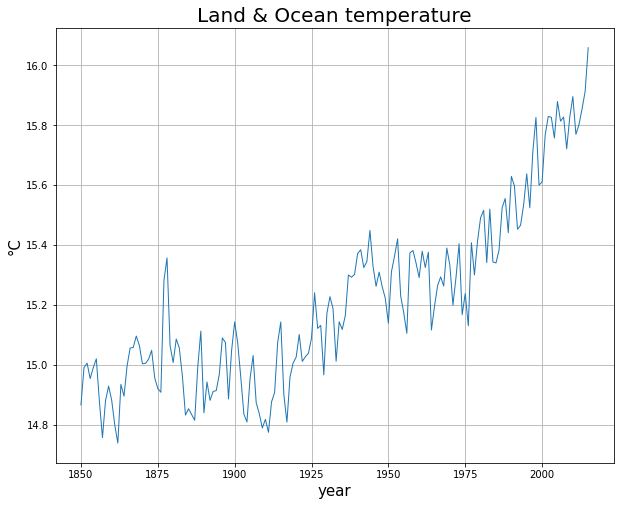

In [11]:
# Plot the year average temperature

avgTemp = earthTemp.groupby(earthTemp.index.year).mean()
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
avgTemp["LandAndOceanAverageTemperature"].plot(linewidth=1)
plt.title('Land & Ocean temperature', fontsize=20)
plt.xlabel('year', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.grid(True)



We could also calculate the average temperature between 1850-2015 and then calculate the difference with respect this long term average as it is usually done for temperature analysis.

In [12]:
meanTemp = earthTemp["LandAndOceanAverageTemperature"].mean()
earthTemp["LandAndOceanAverageTemperatureDelta"] = earthTemp["LandAndOceanAverageTemperature"] - meanTemp

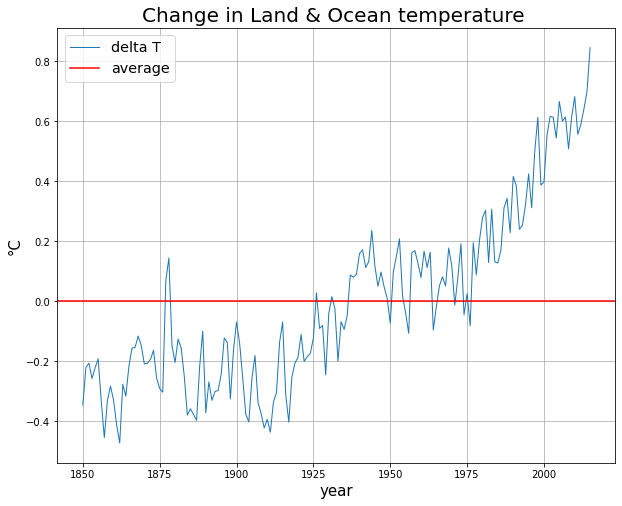

In [13]:
# Plot the difference with respect the mean temperature

avgTemp = earthTemp.groupby(earthTemp.index.year).mean()
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
avgTemp["LandAndOceanAverageTemperatureDelta"].plot(linewidth=1, label ='delta T')
plt.axhline(y=0, color='r', linestyle='-', label = 'average')
plt.title('Change in Land & Ocean temperature ', fontsize=20)
plt.legend(fontsize='x-large')
plt.xlabel('year', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.grid(True)

The same plot could also be seen effectively with a bar plot

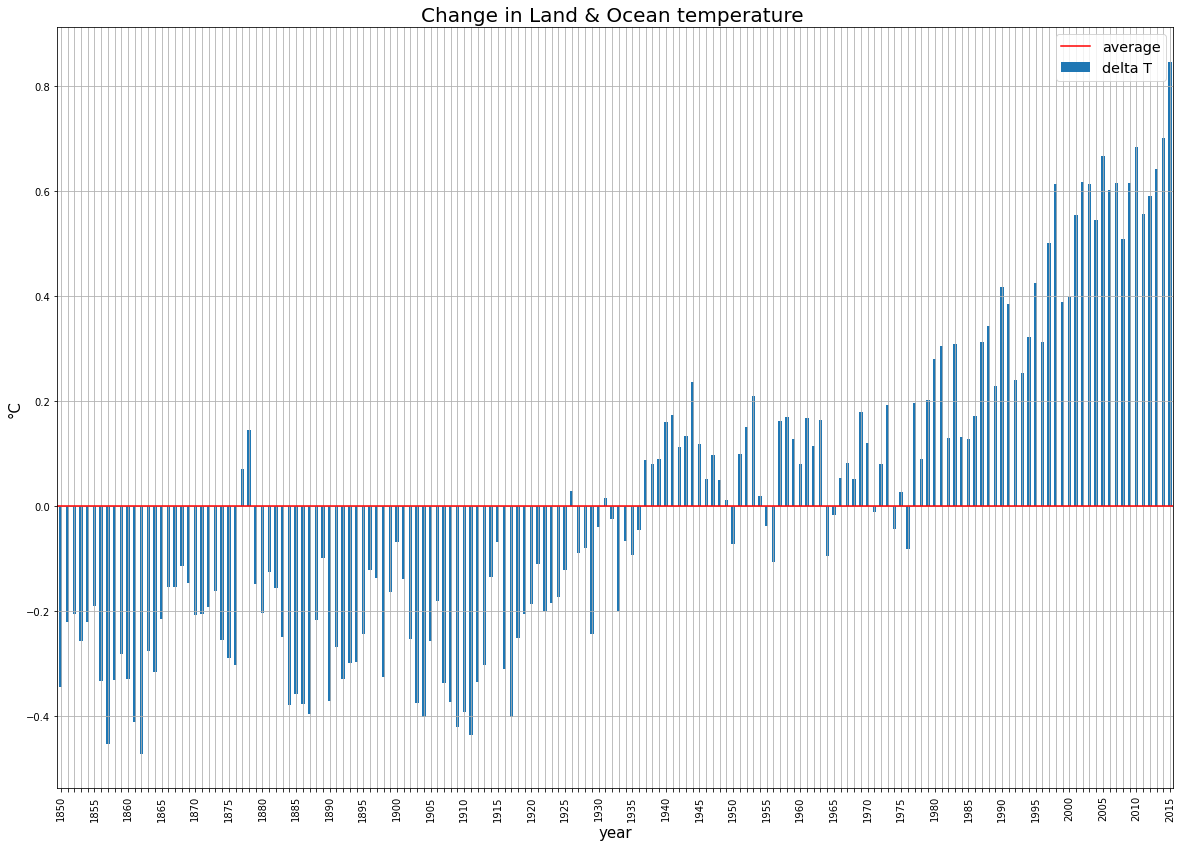

In [14]:
# Plot the difference with respect the mean temperature

avgTemp = earthTemp.groupby(earthTemp.index.year).mean()
fig_dims = (20, 14)
fig, ax = plt.subplots(figsize=fig_dims)
avgTemp["LandAndOceanAverageTemperatureDelta"].plot.bar(linewidth=1, label ='delta T')
plt.axhline(y=0, color='r', linestyle='-', label = 'average')
plt.title('Change in Land & Ocean temperature ', fontsize=20)
plt.legend(fontsize='x-large')
# Show only some xticks
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)
plt.xlabel('year', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.grid(True)

The non-stationarity of the time series can be seen in a convenient way by decomposing the series into its non-stationary elements as below:

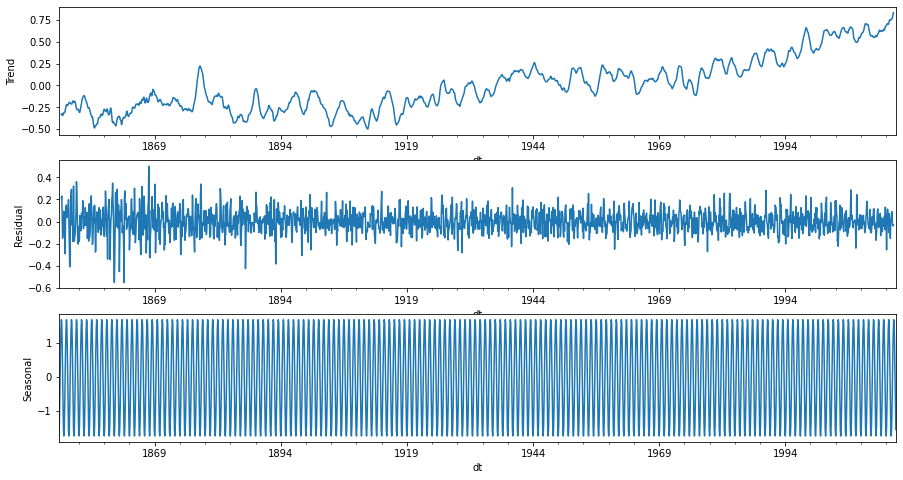

In [15]:
decomposition = sm.tsa.seasonal_decompose(earthTemp["LandAndOceanAverageTemperatureDelta"], model='additive')
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
decomposition.trend.plot(ax=ax1)
ax1.set_ylabel('Trend')
decomposition.resid.plot(ax=ax2)
ax2.set_ylabel('Residual')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
plt.show()

It is quite evident that our series has a trend superimposed on a seasonality. 

In any case, it is also possible to conduct statistical tests to determine the non-stationarity of a time series, as we will do in the next section.

<a id="Time_series_analysis"></a> <br> 
# **3. Time series stationarity analysis** 

## 3.1 *Augmented Dickey Fuller test* <a id="Dickey_Fuller_test"></a>

In order to develop a good auto-regressive model we should have a stationary timeseries. If the series is non-stationary it should be converted to a stationary one.

Just by looking at the previous plot however, we can see that the series exibits a trend (i.e. non stationary). In any case, we can make more accurate checks by applying tests on the time series.

Check the stationarity of the time series ADF (Augmented Dickey Fuller) Test

The Dickey Fuller test could be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. If the test statistic is less than the critical value, we can reject the null hyphotesis (i.e. the series is stationary). If the test statistic is greater than the critical value, we fail to reject the null hypothesis (i.e. the series is not stationary)

In [16]:
# Check the stationarity of the time series
#ADF (Augmented Dickey Fuller) Test

#define function for ADF test
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(earthTemp["LandAndOceanAverageTemperatureDelta"])

Results of Dickey-Fuller Test:
Test Statistic                   -1.135299
p-value                           0.700792
#Lags Used                       26.000000
Number of Observations Used    1965.000000
Critical Value (1%)              -3.433682
Critical Value (5%)              -2.863012
Critical Value (10%)             -2.567554
dtype: float64


In our above example, the test statistic > critical value, which implies that the series is not stationary. However, there are many definitions of stationarity and the results of different tests could be different. In the next section we will try the KPSS test.

## 3.2 *KPSS test* <a id="Kpss_test"></a>

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite with respect to the Augmented Dickey Fuller.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary).

In [17]:
# Define kpss test function
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [18]:
#apply kpss_test on the series
kpss_test(earthTemp["LandAndOceanAverageTemperatureDelta"])

Results of KPSS Test:
Test Statistic            5.025788
p-value                   0.010000
Lags Used                26.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


The test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary).

The difference of the tests is that the ADF test has an alternate hypothesis of linear or difference stationary, while the KPSS test identifies trend-stationarity in a series.

Some definitions:

Strict Stationary: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.

Trend Stationary: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.

Difference Stationary: A time series that can be made strict stationary by differencing. ADF test is also known as a difference stationarity test.

Both tests have shown that the time series is non-stationary.

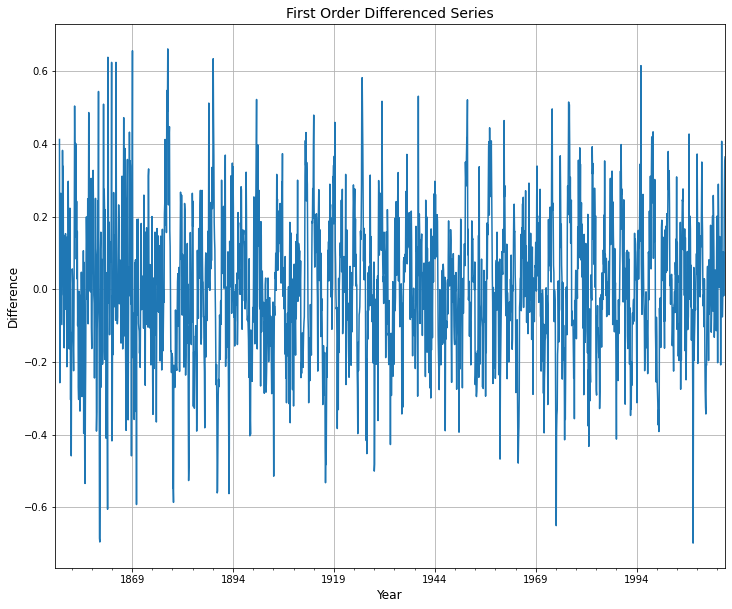

In [19]:
plt.figure(figsize=(12, 10))
earthTemp["LandAndOceanAverageTemperature_diff"] = earthTemp["LandAndOceanAverageTemperatureDelta"].diff(12) # we set 12 that should be the data seasonality because we have monthly data
earthTemp["LandAndOceanAverageTemperature_diff"] = earthTemp["LandAndOceanAverageTemperature_diff"].dropna()
earthTemp["LandAndOceanAverageTemperature_diff"].plot()
plt.title('First Order Differenced Series', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.grid(True)
plt.show()

In [20]:
# See how many null values for each column
# Remove lines where the Lqnd, Oceqn temperqture is null
earthTemp = earthTemp[earthTemp['LandAndOceanAverageTemperature_diff'].notna()]

In [21]:
# Verify again the criteria
#apply adf test on the series
adf_test(earthTemp['LandAndOceanAverageTemperature_diff'])

Results of Dickey-Fuller Test:
Test Statistic                -1.198809e+01
p-value                        3.573912e-22
#Lags Used                     2.400000e+01
Number of Observations Used    1.955000e+03
Critical Value (1%)           -3.433699e+00
Critical Value (5%)           -2.863020e+00
Critical Value (10%)          -2.567558e+00
dtype: float64


In [22]:
kpss_test(earthTemp['LandAndOceanAverageTemperature_diff'])

Results of KPSS Test:
Test Statistic            0.059714
p-value                   0.100000
Lags Used                26.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


We see that just by taking 1 differenciation, we pass both criteria. Therefore, just by taking 1 differenciation we can obtain a stationary series.

<a id="ARIMA"></a> <br> 
# **4. Predictions with ARIMA model** 


ARIMA, autoregressive integrated moving average, is a generalization of an autoregressive moving average (ARMA) model, and combines:

- ****AR****  Autoregression

A future values is predicted as a function of its past values:

$Y_{t} = a + b_1 Y_{t-1} + b_2 Y_{t-2} + b_3 Y_{t-3}$

The dependency from the past values is defined by the parameter p. In this case p=3, (i.e. the future values depends on the past 3 values)


- ****MR****  Moving average

The predicted variable $Y_{t}$ depends on error of the previous lagged values

$Y_{t} = a + E_{t} + b_1 E_{t-1} + b_2 E_{t-2}$

The dependency from past errors values is defined by the values q

- ****I****  Integrated

It differences the data to remove trend and make it stationary. It is defined by the parameter d (i.e. the number of differencing to make the time series stationary)

Therefore, the ARIMA model is the combination of these 3 model and it is defined by parameters (d,q,d)


However, the ARIMA model is not able to take care of seasonality. This can be done by the SARIMA model (i.e. Seasonal ARIMA).
It adds more 4 more parameters P,D,Q,m:

- P is Seasonal AR term
- Q is seasonal MA term
- D is seasonal difference order
- m is the number of time steps for a single seasonal period

In [23]:
# Create a separate dataset for our predictions
series = pd.DataFrame(data=earthTemp['LandAndOceanAverageTemperatureDelta'])
series.index = earthTemp.index

Usually when building a model we should split the original series in train and test set. However, the time series demonstrates a particular behaviour in the last 40th years. To avoid to lose information, I decide to use the whole time series to select hyperparameters and to train the model.

From the previous analysis we saw that the time series is a non stationary series. 
This results could be found also thanks to the Automatic determination of SARIMA parameters.

In [24]:
# The function is very expensive from a computational point of view and takes up to 20 minutes to run. 
# If you do not want to wait, the optimal parameters have already been found and are those used in the next step.
# Obs. for the trend we try with 'ct', constant + linear, however we have seen that the trend of the temperature time series is more complex
# Another possibility, would be to eliminate the trend by differencing. 
# In this case, the predicted results would refer to the differenced series and in order to get the results related to the original series 
# we would need invert the differentiation.
# However, here, we try to impose a 'ct' trend (constant+linear).
# The search for these parameters is limited by the space available in memory, 
# I was forced to limit the search for these parameters due to memory problems in kaggle



model = auto_arima(series['LandAndOceanAverageTemperatureDelta'], 
                       start_p=1,
                       start_q=1,
                       max_p=3,
                       max_q=3,
                       start_P=1,
                       start_Q=1,
                       max_P=2,
                       max_Q=2,
                       m=12,
                       seasonal=True,
                       d=1,
                       D=1,
                       trend = 'ct',
                       test = 'adf',
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-2297.778, Time=19.95 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1179.518, Time=0.84 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1931.524, Time=3.69 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-2342.886, Time=14.77 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-1500.475, Time=2.94 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-2254.227, Time=17.13 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-2362.802, Time=35.36 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-2367.879, Time=40.34 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-2339.882, Time=45.39 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-2221.124, Time=37.57 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-2059.062, Time=31.12 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-2407.026, Time=43.84 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-2400.637, Time=38.79 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=-2381.241, Time=48.7

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


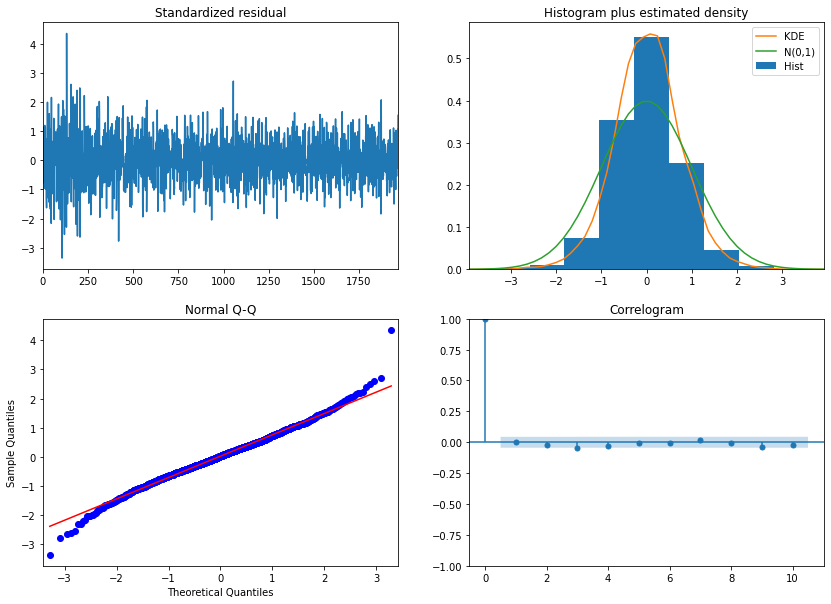

In [25]:
# Show diagnosis parameters
model.plot_diagnostics(figsize=(14,10))
plt.show()

How to interpret the previous plots?

-**Standardized residual** There should be no obvious patterns in the residuals --> ok

-**Histogram plus kde estimate** The KDE curve should be very similar to the normal distribution --> seems to be centered (but the peaks are quite far)

-**Normal Q-Q** Most of the data points should lie on the straight line --> Ok (even if we have some points quite far from the straight line at start and at the end)

-**Correlogram** In order to have a good git the 95% of correlations for lag greater than one should not be significant --> Ok

The previous charts shows that we have found a pretty good model but there is certainly room for improvement, such as better modeling of the trend.

In [26]:
# Construct the model
# We create a SARIMAX model using the parameter found at previous step
# As we have seen in our previous analysis the trend of the temperature time series is quite complicated and irregular. 
# We try with a 'ct' trend --> This step could be improved by modeling the trend of the time series or by removing the trend (i.e. by differencing).
# We need also to specify the seasonality so we add a seasonal_order (where 12 is the seasonality, 
# we have monthly data so the seasonality is 12)
# As done previously, we don't need to care to give in input the differenced time series, because the SARIMAX function will automatically take care
# fo this step (we specify the d parameter=1)

mod = sm.tsa.SARIMAX(series['LandAndOceanAverageTemperatureDelta'], order=(0, 1, 3), seasonal_order=(1,1,[1, 2],12), trend='ct')
# Estimate the parameters
res = mod.fit()

print(res.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                        SARIMAX Results                                        
Dep. Variable:     LandAndOceanAverageTemperatureDelta   No. Observations:                 1980
Model:             SARIMAX(0, 1, 3)x(1, 1, [1, 2], 12)   Log Likelihood                1226.580
Date:                                 Mon, 31 May 2021   AIC                          -2435.160
Time:                                         22:08:06   BIC                          -2384.901
Sample:                                     01-01-1851   HQIC                         -2416.690
                                          - 12-01-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0006      0.001     -0.596      0.551      -0.003       0

## In-sample predictions

In [27]:
# Now that we have fitted the data we can plot the fitted results and compare them wrt original data
# We just need to specify the start and end index
# The start index is date of the first sample in our training dataset, the end index is the last index of the last sample in our training dataset

startDate = series.index[0]
endDate = series.index[-1]
predicted = res.predict(start=startDate, end=endDate)
series['LandAndOceanAverageTemperaturePredictions'] = predicted

In [28]:
# Compute the mean squared error between the predicted series and the original series 
print('The mean squared error is:', mean_squared_error(series['LandAndOceanAverageTemperatureDelta'],series['LandAndOceanAverageTemperaturePredictions']))

The mean squared error is: 0.019116215864151177


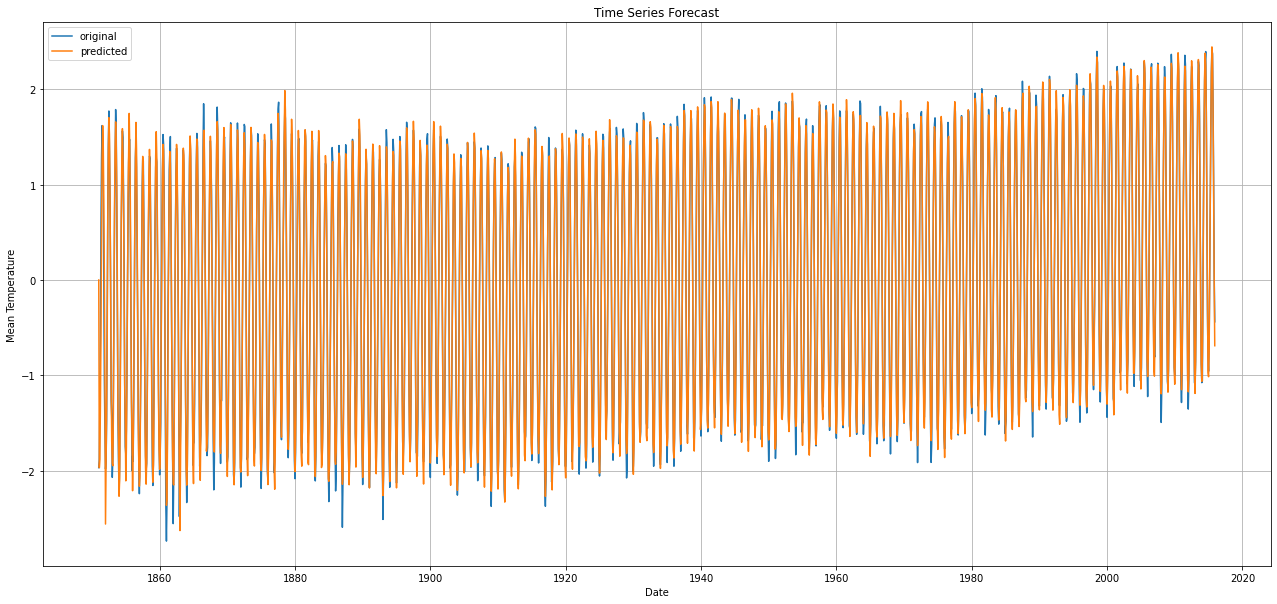

In [29]:
plt.figure(figsize=(22,10))
plt.plot(series.index,series['LandAndOceanAverageTemperatureDelta'],label = "original")
plt.plot(series['LandAndOceanAverageTemperaturePredictions'],label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.grid(True)
plt.show()

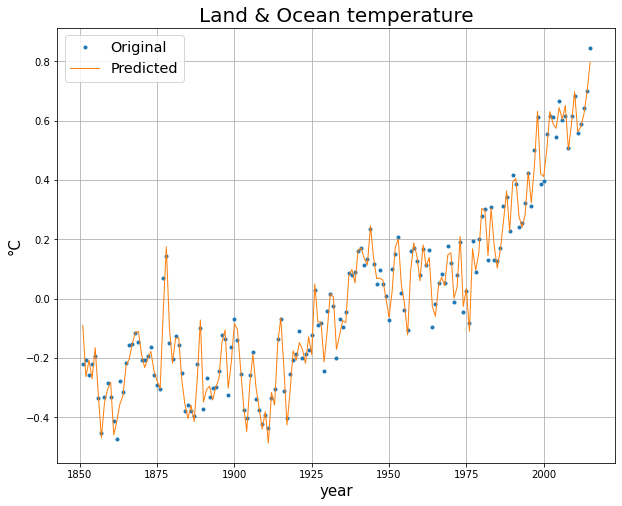

In [30]:
# We could have a better view taking the average for each year

# Convert dt column elements to datetime object
#earthTemp.index = pd.to_datetime(earthTemp.index, format='%Y-%d-%m')
# Get the average temperature for each year and plot the global trend from 1750 year
avgTemp = series.groupby(series.index.year).mean()
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
avgTemp["LandAndOceanAverageTemperatureDelta"].plot(marker='.', linestyle="None", label='Original')
avgTemp["LandAndOceanAverageTemperaturePredictions"].plot(linewidth=1, label='Predicted')
plt.title('Land & Ocean temperature', fontsize=20)
plt.xlabel('year', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.legend(fontsize='x-large')
plt.grid(True)


## Out-of-sample predictions (forecast)

In [31]:
# To make predictions in 40 years, we need to multiply the number of sample per year (12) for 40
nbStep = 12*40
forecast = res.get_forecast(steps=nbStep)

In [32]:
# Get a datadictionary with predictions and confidence intervals
forecast = forecast.summary_frame()

In [33]:
# Create a dataframe with the forecast values and the upper and lower values at 95% confidence level
forecasts = pd.DataFrame(columns = ['LandAndOceanAverageTemperaturePredictions','LandAndOceanAverageTemperaturePredictionsUpper','LandAndOceanAverageTemperaturePredictionsLower'])
forecasts['LandAndOceanAverageTemperaturePredictions'] = forecast['mean']
forecasts['LandAndOceanAverageTemperaturePredictionsUpper'] = forecast['mean_ci_upper']
forecasts['LandAndOceanAverageTemperaturePredictionsLower'] = forecast['mean_ci_lower']
forecasts.index = forecast.index

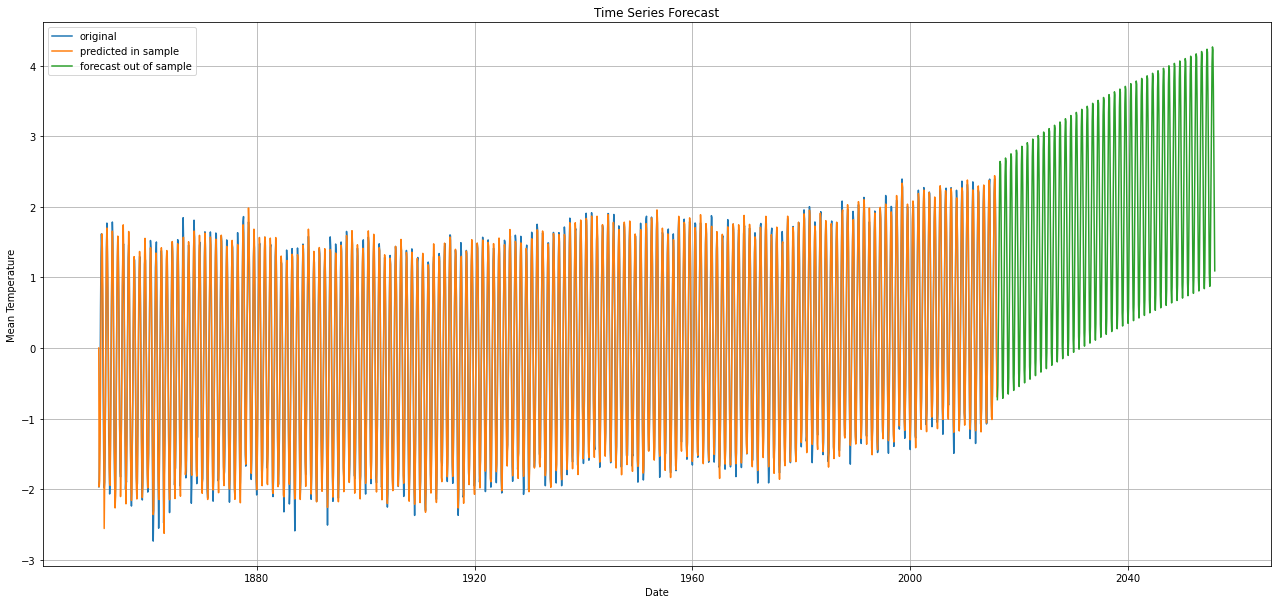

In [34]:
plt.figure(figsize=(22,10))
plt.plot(series.index,series['LandAndOceanAverageTemperatureDelta'],label = "original")
plt.plot(series['LandAndOceanAverageTemperaturePredictions'],label = "predicted in sample")
plt.plot(forecasts['LandAndOceanAverageTemperaturePredictions'],label = "forecast out of sample")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.grid(True)
plt.show()

We will now plot the average land/ocean temperature of each year.  

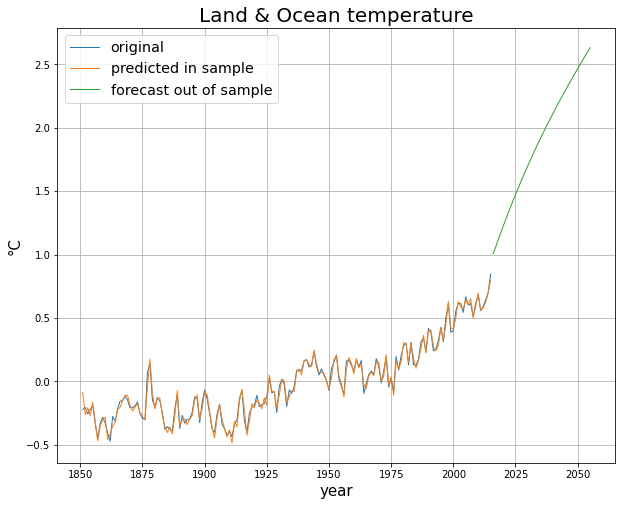

In [35]:
avgTemp = series.groupby(series.index.year).mean()
avgTempPred = forecasts.groupby(forecasts.index.year).mean()
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
avgTemp["LandAndOceanAverageTemperatureDelta"].plot(linewidth=1, label='original')
avgTemp["LandAndOceanAverageTemperaturePredictions"].plot(linewidth=1, label='predicted in sample')
avgTempPred["LandAndOceanAverageTemperaturePredictions"].plot(linewidth=1, label='forecast out of sample')
#ax.fill_between(avgTempPred.index, avgTempPred['LandAndOceanAverageTemperaturePredictionsLower'], avgTempPred['LandAndOceanAverageTemperaturePredictionsUpper'], color='k', alpha=0.1);
plt.title('Land & Ocean temperature', fontsize=20)
plt.xlabel('year', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.legend(fontsize='x-large')
plt.grid(True)

We plot the in sample predictions and the out of sample predictions with upper and lower confidence intervals of 95%.

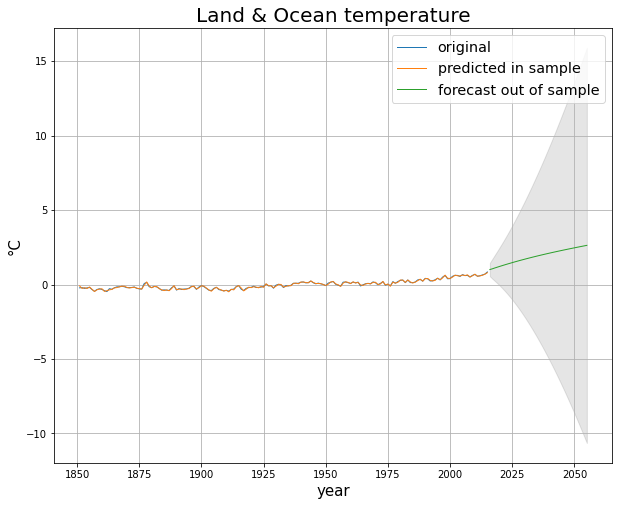

In [36]:
avgTemp = series.groupby(series.index.year).mean()
avgTempPred = forecasts.groupby(forecasts.index.year).mean()
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
avgTemp["LandAndOceanAverageTemperatureDelta"].plot(linewidth=1, label='original')
avgTemp["LandAndOceanAverageTemperaturePredictions"].plot(linewidth=1, label='predicted in sample')
avgTempPred["LandAndOceanAverageTemperaturePredictions"].plot(linewidth=1, label='forecast out of sample')
ax.fill_between(avgTempPred.index, avgTempPred['LandAndOceanAverageTemperaturePredictionsLower'], avgTempPred['LandAndOceanAverageTemperaturePredictionsUpper'], color='k', alpha=0.1);
plt.title('Land & Ocean temperature', fontsize=20)
plt.xlabel('year', fontsize=15)
plt.ylabel('°C', fontsize=15)
plt.legend(fontsize='x-large')
plt.grid(True)

Obviously for periods much later in time, the probability margins will be very large.

Current studies by NASA estimates that the temperature will rise up 2° in 2050 with respect to the long term average if we continue with our national policies. 

My model shows a possible increase of 2.5°. To compare the models, however, it would be necessary to use the same data and report these increases over the same time period with respect to the long-term average (as a reminder, in the present kernel the variations are referred to the long-term average between 1850 and 2015.). 

Potential improvements of the current work could be a better selection of hyperparameters for the SARIMAX model (with a better modeling of the trend). We could also add uncertainties about the measurements that are available in the dataset and that were not used in this work.

<a id="Conclusions"></a> <br> 
# **5. Conclusions** 

In this kernel we have learned:

- Basic analysis of a time series. Visual inspection to determine stationarity or not
- Criteria for determining stationarity in a rigorous way
- ARIMA and SARIMA models to make in-sample predictions and out-of-samples forecast
- Studied the historical series of Earth Land and Oceans temperature

Global warming is a critical issue that will have a very important impact on our lives in the coming years. I hope this notebook can also help raise awareness of people's opinion on the subject.

I hope you enjoyed this kernel and thank you for taking the time to read it.